### Импорт

In [2]:
import os
import re
import dill
import datetime
import numpy as np

In [3]:
from matplotlib import pyplot as plt
%matplotlib widget
import matplotlib
matplotlib.use('nbagg')
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams.update({'font.size': 14})
# matplotlib.rcParams.update({'font.family': 'serif'})
# matplotlib.rcParams.update({'text.latex.preamble': 
#                             r'\usepackage[russian]{babel}\usepackage{amsmath}'})

In [4]:
import os
os.getcwd()

'/home/dobri/atmrad/+/2023'

In [5]:
import sys
sys.path.append('/home/dobri/atmrad')

In [6]:
from cpu.cloudiness import Plank3D
from cpu.core.multi import *

In [ ]:
from cpu.atmosphere import Atmosphere as AtmosphereCPU
from cpu.surface import SmoothWaterSurface as SmoothWaterSurfaceCPU

In [20]:
from gpu.atmosphere import Atmosphere as AtmosphereGPU
from gpu.surface import SmoothWaterSurface as SmoothWaterSurfaceGPU

### Глобальные параметры

In [7]:
# domain parameters
H = 20.  # высота атмосферы
d = 100  # дискретизация по высоте
X = 50  # (км) горизонтальная протяженность моделируемой атмосферной ячейки
res = 300  # горизонтальная дискретизация

In [8]:
seed = 42  # состояние генератора случайных чисел

In [15]:
# observation parameters
angle = 0. * np.pi / 180.  # зенитный угол наблюдения, по умолчанию: 0
integration_method = 'trapz'   # метод численного интегрирования

In [16]:
# atmosphere parameters
T0 = 15.   # температура у поверхности
P0 = 1013   # атмосферное давление у поверхности
rho0 = 7.5   # абсолютная влажность воздуха у поверхности

In [17]:
# surface parameters
surface_temperature = 15.   # температура воды на поверхности
surface_salinity = 0.    # солёность

In [18]:
# radiation parameters
polarization = None    # поляризация вертикальная
frequencies = [22.2, 27.2, 36, 89]   # частоты в ГГц

### Подготовка 2D карт распределения облаков согласно модели Планка (300х300 узлов ~ 50x50 км)

In [21]:
base_distributions = [
    {'name': 'L2', 'alpha': 1.411, 'Dm': 4.026, 'dm': 0.02286, 'eta': 0.93, 'beta': 0.3, 'cl_bottom': 1.2192},
    {'name': 'L3', 'alpha': 1.485, 'Dm': 4.020, 'dm': 0.03048, 'eta': 0.76, 'beta': -0.3, 'cl_bottom': 1.3716},
    {'name': 'T7', 'alpha': 1.35, 'Dm': 3.733, 'dm': 0.04572, 'eta': 1.2, 'beta': 0.0, 'cl_bottom': 1.24968},
    {'name': 'T6', 'alpha': 1.398, 'Dm': 3.376, 'dm': 0.03048, 'eta': 0.93, 'beta': -0.1, 'cl_bottom': 1.0668},
    {'name': 'T8', 'alpha': 1.485, 'Dm': 4.02, 'dm': 0.06096, 'eta': 1.2, 'beta': 0.4, 'cl_bottom': 1.3716},
    {'name': 'T9', 'alpha': 2.485, 'Dm': 2.656, 'dm': 0.04572, 'eta': 1.3, 'beta': 0.3, 'cl_bottom': 1.40208},
    
    {'name': 'L1', 'alpha': 3.853, 'Dm': 1.448, 'dm': 0.01524, 'eta': 0.98, 'beta': 0.0, 'cl_bottom': 0.54864},
    {'name': 'T5', 'alpha': 2.051, 'Dm': 2.574, 'dm': 0.02286, 'eta': 0.85, 'beta': -0.13, 'cl_bottom': 1.11252},
    {'name': 'T3', 'alpha': 2.361, 'Dm': 2.092, 'dm': 0.01524, 'eta': 0.93, 'beta': -0.1, 'cl_bottom': 0.82296},
    {'name': 'T4', 'alpha': 2.703, 'Dm': 2.094, 'dm': 0.02286, 'eta': 0.8, 'beta': 0.0, 'cl_bottom': 0.9144},
    {'name': 'T2', 'alpha': 4.412, 'Dm': 1.126, 'dm': 0.01524, 'eta': 0.97, 'beta': 0.0, 'cl_bottom': 0.70104},
    {'name': 'T1', 'alpha': 9.07, 'Dm': 0.80485, 'dm': 0.01524, 'eta': 0.89, 'beta': 0.0, 'cl_bottom': 0.67056},
]

In [ ]:
distributions = []
for base_distr in base_distributions:
    distributions.append(base_distr)
    for i, beta in enumerate(np.arange(-0.9, 0.9, 0.1)):
        new_distr = base_distr.copy()
        new_distr['name'] += 'B' + str(i).zfill(2)
        new_distr['beta'] = np.round(beta, decimals=1)
        distributions.append(new_distr)
    for j, eta in enumerate(np.arange(0.53, 1.83, 0.1)):
        new_distr = base_distr.copy()
        new_distr['name'] += 'E' + str(j).zfill(2)
        new_distr['eta'] = np.round(eta, decimals=2)
        distributions.append(new_distr)
len(distributions)

In [ ]:
# SEQUENTIAL

percentage = np.linspace(0.2, 0.7, 20, endpoint=True)[::-1]

if not os.path.exists('HMAP'):
    os.makedirs('HMAP')

start_time = datetime.datetime.now()

for i, distr in enumerate(distributions):
    print('\n\nProcessing {} ...\t|\t {} left out of {}\n'.format(distr['name'], 
                                                                 len(distributions) - i, 
                                                                 len(distributions)))
    alpha, Dm, dm, eta, beta, cl_bottom = \
        distr['alpha'], distr['Dm'], distr['dm'], distr['eta'], distr['beta'], distr['cl_bottom']
    
    xi = -np.exp(-alpha * Dm) * (((alpha * Dm) ** 2) / 2 + alpha * Dm + 1) + \
        np.exp(-alpha * dm) * (((alpha * dm) ** 2) / 2 + alpha * dm + 1)
    print('xi\t', xi)
    
    for j, required_percentage in enumerate(percentage):
        print('\n\nRequired %: {:.2f}'.format(required_percentage * 100.))
        K = 2 * np.power(alpha, 3) * (X * X * required_percentage) / (np.pi * xi)
        print('K\t', K)
    
        p = Plank3D(kilometers=(X, X, H), nodes=(res, res, d), clouds_bottom=cl_bottom)
        print('Generating cloud distribution...')
        try:
            clouds = p.generate_clouds(
                Dm=Dm, dm=dm, K=K, alpha=alpha, beta=beta, eta=eta, seed=seed, timeout=1., verbose=True
            )
        except TimeoutError:
            print('\n ...time is over')
            continue
            
        N_analytical = K / alpha * (np.exp(-alpha * dm) - np.exp(-alpha * Dm))
        N_fact = len(clouds)
        print('N\tanalytical: {}\t\tactual: {}'.format(N_analytical, N_fact))
        
        hmap = p.height_map2d_(clouds)
        
        sky_cover = np.sum(np.pi * np.power(np.array([cloud.rx for cloud in clouds]), 2))
        cover_percentage = sky_cover / (X * X)
        cover_percentage_d = np.count_nonzero(hmap) / (res * res)
        sky_cover_d = cover_percentage_d * (X * X)
        
        print('%\tbefore digitizing: {}\t\tafter digitizing: {}'.format(
            cover_percentage * 100., cover_percentage_d * 100.))
        
        with open(os.path.join('HMAP',
                      distr['name'] + '_P' + str(int(np.round(required_percentage * 100., decimals=0))) + '.map'), 
                  'wb') as file:
            dill.dump(np.asarray(hmap), file, recurse=True)
            
        print('{:.2f}% READY'.format((j + 1) / len(percentage) * 100.))
        
        elapsed = datetime.datetime.now() - start_time
        days = elapsed.days
        hours = elapsed.seconds // 3600
        minutes = (elapsed.seconds - hours * 3600) // 60
        seconds = elapsed.seconds - hours * 3600 - minutes * 60
        print('\nElapsed: {} d\t{} h\t{} m\t{} s'.format(days, hours, minutes, seconds))

In [ ]:
# PARALLEL

percentage = np.linspace(0.2, 0.7, 20, endpoint=True)[::-1]

n_workers = 8

if not os.path.exists('HMAP'):
    os.makedirs('HMAP')

def process(distr:  dict) -> None:
    alpha, Dm, dm, eta, beta, cl_bottom = \
        distr['alpha'], distr['Dm'], distr['dm'], distr['eta'], distr['beta'], distr['cl_bottom']

    xi = -np.exp(-alpha * Dm) * (((alpha * Dm) ** 2) / 2 + alpha * Dm + 1) + \
        np.exp(-alpha * dm) * (((alpha * dm) ** 2) / 2 + alpha * dm + 1)

    for j, required_percentage in enumerate(percentage):
        K = 2 * np.power(alpha, 3) * (X * X * required_percentage) / (np.pi * xi)

        p = Plank3D(kilometers=(X, X, H), nodes=(res, res, d), clouds_bottom=cl_bottom)
        try:
            clouds = p.generate_clouds(
                Dm=Dm, dm=dm, K=K, alpha=alpha, beta=beta, eta=eta, seed=seed, timeout=1., verbose=False,
            )
        except TimeoutError:
            continue

        hmap = p.height_map2d_(clouds)

        with open(os.path.join('HMAP',
                               distr['name'] + '_P' + str(
                                   int(np.round(required_percentage * 100., decimals=0))) + '.map'),
                  'wb') as file:
            dill.dump(np.asarray(hmap), file, recurse=True)

        print('\r{}\t --- \t{:.2f}% READY '.format(distr['name'], (j + 1) / len(percentage) * 100.),
              end='    ', flush=True)
        
    
with Manager() as manager:
    processes = []
    for i, d in enumerate(distributions):
        p = Process(target=process, args=(d,))
        processes.append(p)
    do(processes, n_workers)

###### проверка

In [12]:
with open('HMAP/L2_P67.map', 'rb') as file:
    hmap = dill.load(file)
    
type(hmap)

numpy.ndarray

<IPython.core.display.Javascript object>


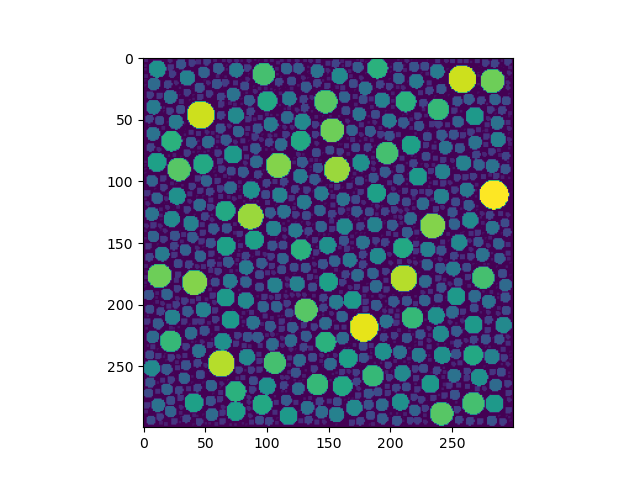

In [13]:
plt.figure()
plt.imshow(hmap)

In [ ]:
np.unique(hmap)

### Генерация изображений по полученным картам мощностей

In [ ]:
if not os.path.exists('HMAPIMGS'):
    os.makedirs('HMAPIMGS')

names = [re.sub('.map', '', f) for f in os.listdir('HMAP') if os.path.isfile(os.path.join('HMAP', f))]
paths = [os.path.join('HMAP', name + '.map') for name in names]
paths

In [ ]:
vmax = 0
for path in paths:
    
    if path.find('L2') == -1:  # только L2-распределения
        continue
        
    with open(path, 'rb') as file:
        hmap = dill.load(file)
    current_max = np.max(hmap)
    if current_max > vmax:
        vmax = current_max
vmax

In [ ]:
for name, path in zip(names[::], paths[::]):
    
    if path.find('L2') == -1:   # только L2-распределения
        continue
        
    with open(path, 'rb') as file:
        hmap = dill.load(file)

    plt.figure()
    ax = plt.gca()
    ax.axis('off')
    plt.imshow(hmap, vmin=0., vmax=vmax)
    plt.savefig(os.path.join('HMAPIMGS', name + '.png'), dpi=300)

### Сжатие полученных 2D-карт

In [ ]:
names = [re.sub('.map', '', f) for f in os.listdir('HMAP') if os.path.isfile(os.path.join('HMAP', f))]
paths = [os.path.join('HMAP', name + '.map') for name in names]
names

In [ ]:
if not os.path.exists('HDAT'):
    os.makedirs('HDAT')

for j, (path, name) in enumerate(zip(paths, names)):
    print('\r{} out of {} ready   '.format(j+1, len(names)), end='    ', flush=True)
    
    with open(path, 'rb') as file:
        hmap = dill.load(file)
        
    unique_vals = np.unique(hmap)
    masks = [np.moveaxis(np.asarray(np.where(np.isclose(h, hmap) == True)), 0, -1) 
             for h in unique_vals]

    _d = {}
    for i, val in enumerate(unique_vals):
        _d[val] = masks[i]
    
    with open(os.path.join('HDAT', name + '.dat'), 'wb') as dat:
        dill.dump(_d, dat, recurse=True)

#### проверка

In [2]:
import dill
with open('HDAT/L2_P67.dat', 'rb') as dat:
    _d = dill.load(dat)
    
type(_d)

dict

In [4]:
len(_d.keys())

34

In [10]:
newmap = np.zeros((300, 300), dtype=float)
keys = _d.keys()
for k, key in enumerate(keys):
    print('\r{} out of {}   '.format(k+1, len(keys)), end='   ', flush=True)
    for i, j in _d[key]:
        newmap[i, j] = key

34 out of 34      

<IPython.core.display.Javascript object>


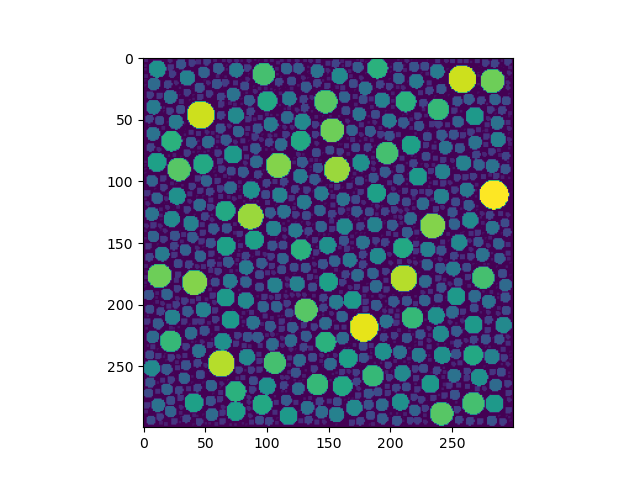

In [11]:
plt.figure()
plt.imshow(newmap)